### PSATITP

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

from data_import import import_precipitation_ts, get_plants
from data_analysis import  is_stationary, plot_acf_pacf, precipitation_plots
from prediction import split_train_test_by_size, cross_validation, test

### Importing data

In [2]:
ts_dict = import_precipitation_ts()
plants = get_plants()
plant_on_analysis = "PSATITP"

### Data Analysis


In [ ]:
precipitation_plots(ts_dict, plant_on_analysis)

In [ ]:
is_stationary(ts_dict, "PSATITP")

In [ ]:
plot_acf_pacf(ts_dict, "PSATITP")

### Preparing Data for Prediction

In [56]:
df = ts_dict[plant_on_analysis].dropna(axis=0)
X_train, X_test, y_train, y_test = split_train_test_by_size(df, 100)

In [4]:
dfcg = df.copy()
c = pd.read_csv(f"../data/ts-{plant_on_analysis}-cfs-model.csv", index_col=[0])
g = pd.read_csv(f"../data/ts-{plant_on_analysis}-gefs-model.csv", index_col=[0])
cg_df = pd.concat([c, g], axis=1).dropna(axis=0)
# dfcg = pd.concat([dfcg, c, g], axis=1).dropna(axis=0)
# X_traincg, X_testcg, y_traincg, y_testcg = split_train_test_by_size(dfcg)

In [57]:
mask = np.ones(X_train.shape[1], dtype=bool)
mask[15:45] = False
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

### Hyperparameters search

In [41]:
tscv = TimeSeriesSplit(n_splits=5)

In [58]:
param_grid_knn = {
    'n_neighbors': range(1, 15),
    'p': [1, 2, 3],
}

grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'n_neighbors': 14, 'p': 1}

In [59]:
param_grid_rf = {
    'n_estimators': [20, 50, 80, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 4, 'n_estimators': 100}

In [60]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=tscv, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}

### Models

In [61]:
knn = KNeighborsRegressor(**best_params_knn)
rf = RandomForestRegressor(**best_params_rf, criterion="squared_error", random_state=0)
xgb = XGBRegressor(**best_params_xgb)

### Prediction without cfs and gefs

Evaluation 0:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 778  | 8.16 | 4.98 |
| Validation | 777  | 8.76 | 5.73 |
+------------+------+------+------+

Evaluation 1:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 1555 | 8.07 | 5.09 |
| Validation | 777  | 7.48 | 5.03 |
+------------+------+------+------+

Evaluation 2:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 2332 | 7.64 | 4.75 |
| Validation | 777  | 6.32 | 4.26 |
+------------+------+------+------+

Evaluation 3:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 3109 | 7.19 | 4.35 |
| Validation | 777  | 8.54 | 5.14 |
+------------+------+------+------+

Evaluation 4:
+------------+------+------+------+
|            | Size | RMSE

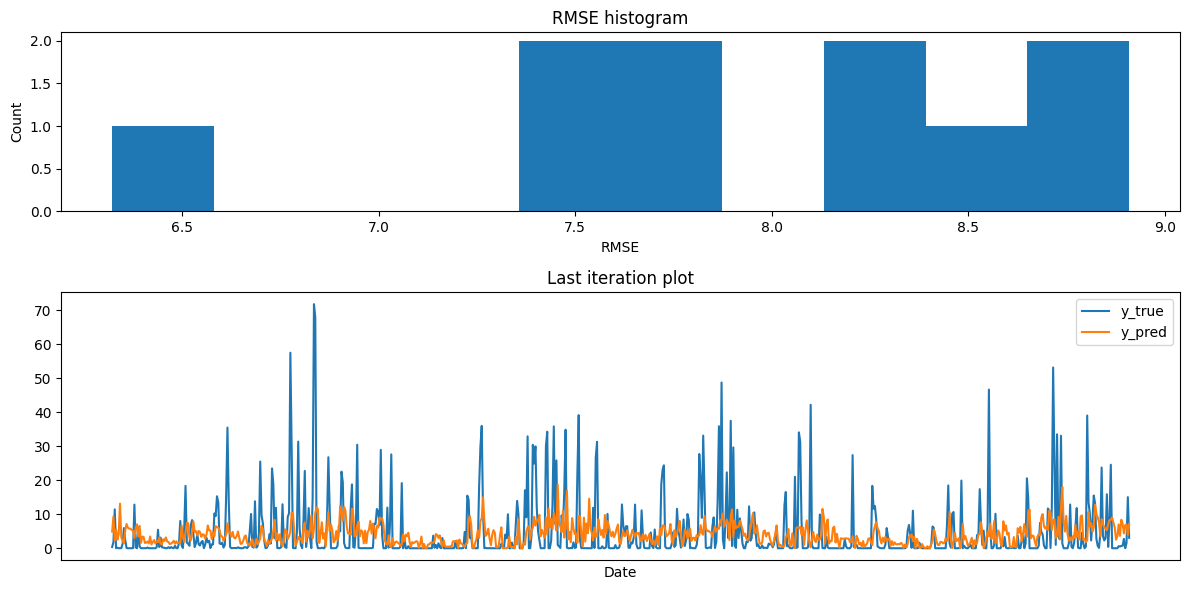

In [62]:
cross_validation(knn, X_train, y_train)

Evaluation 0:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 778  | 6.82 | 4.34 |
| Validation | 777  | 8.45 | 5.22 |
+------------+------+------+------+

Evaluation 1:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 1555 | 7.34 | 4.64 |
| Validation | 777  | 6.94 | 4.37 |
+------------+------+------+------+

Evaluation 2:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 2332 | 7.19 | 4.45 |
| Validation | 777  | 6.03 | 3.96 |
+------------+------+------+------+

Evaluation 3:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 3109 | 6.92 | 4.28 |
| Validation | 777  | 8.15 | 5.01 |
+------------+------+------+------+

Evaluation 4:
+------------+------+------+------+
|            | Size | RMSE

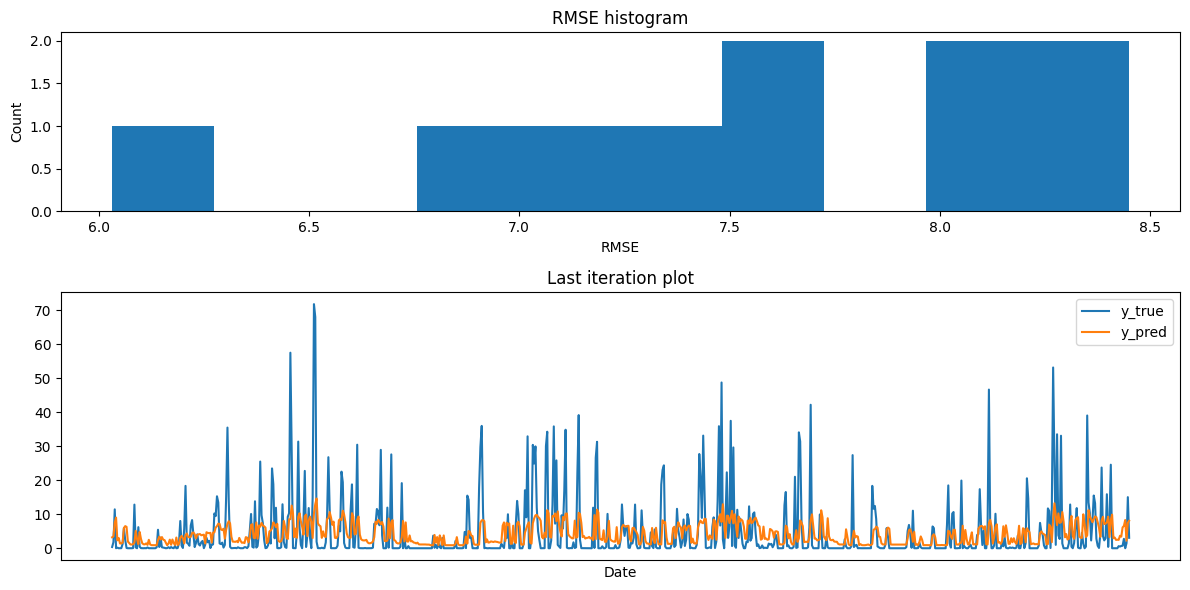

In [63]:
cross_validation(rf, X_train, y_train)

Evaluation 0:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 778  | 4.77 | 3.09 |
| Validation | 777  | 8.66 | 5.51 |
+------------+------+------+------+

Evaluation 1:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 1555 | 6.21 | 3.89 |
| Validation | 777  | 7.19 | 4.64 |
+------------+------+------+------+

Evaluation 2:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 2332 | 6.26 | 3.90 |
| Validation | 777  | 6.05 | 3.92 |
+------------+------+------+------+

Evaluation 3:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 3109 | 6.21 | 3.85 |
| Validation | 777  | 8.21 | 4.92 |
+------------+------+------+------+

Evaluation 4:
+------------+------+------+------+
|            | Size | RMSE

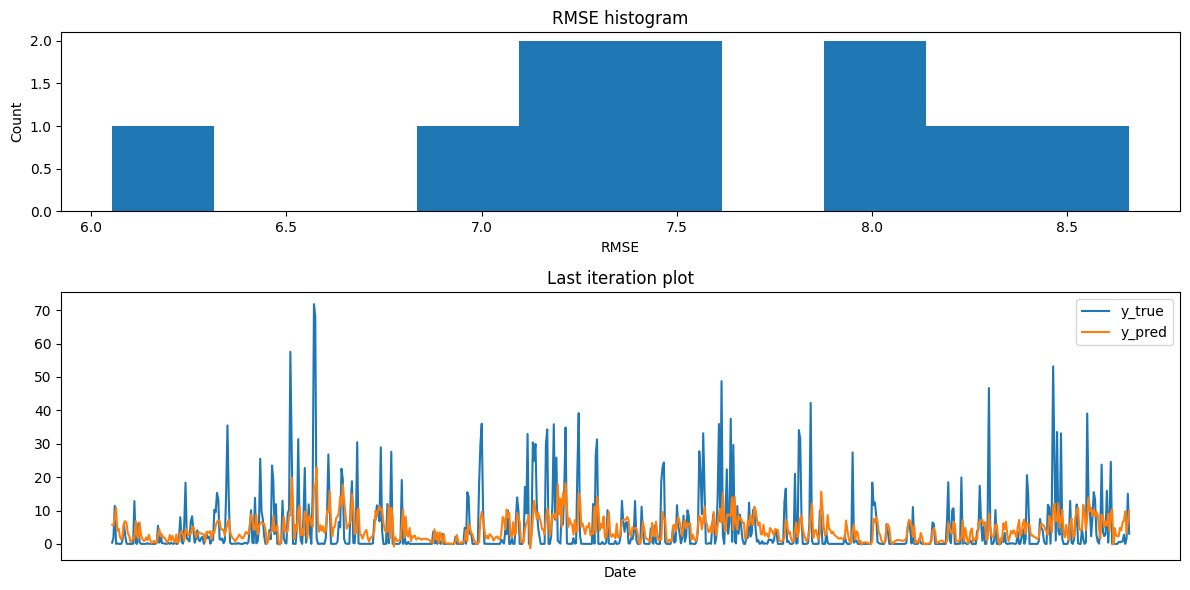

In [64]:
cross_validation(xgb, X_train, y_train)

### Prediction with cfs and gefs

In [ ]:
cross_validation(knn, X_traincg, y_traincg)

In [ ]:
cross_validation(rf, X_traincg, y_traincg)

In [ ]:
cross_validation(xgb, X_traincg, y_traincg)

### Test scores

#### Without cfs and gefs

In [65]:
test(knn, X_train, X_test, y_train, y_test)

Test RMSE: 4.19
Test  MAE: 3.06


In [66]:
test(rf, X_train, X_test, y_train, y_test)

Test RMSE: 4.14
Test  MAE: 3.19


In [67]:
test(xgb, X_train, X_test, y_train, y_test)

Test RMSE: 4.05
Test  MAE: 2.96


#### With cfs and gefs

In [54]:
test(knn, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.759999772250188


In [55]:
test(rf, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.1857706478512


In [57]:
test(xgb, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.294003083625308
